# “火炬上的深度学习"第一次大作业

在这个作业中，你需要半独立地利用人工神经网络搭建一个手写数字识别器

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [118]:

"""简单的 LeNet-5类型的卷积神经网络模型，MNIST例子.
"""

#所有依赖包

import gzip
import os
import sys

import numpy as np
from six.moves import urllib
import torch
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pylab as plt

#定义一系列常数
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/' #图像数据如果没下载，可以从这个地址下载
WORK_DIRECTORY = 'data' #存储的路径名
IMAGE_SIZE = 28 #每张图片的大小尺寸
NUM_CHANNELS = 1  #每张图片的通道数
PIXEL_DEPTH = 255 #像素的深度0-255
NUM_LABELS = 10 #手写数字，一共十种

%matplotlib inline

CAN_GPU=torch.cuda.is_available()

# 读取MINST图形文件

In [119]:
#下载图像文件，如果文件已经存在，那么就不下载。
def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.isdir(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        size = os.path.getsize(filepath)
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath
# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

def extract_data(filename, num_images):
    # filename: 文件存放的路径，num_images: 读入的图片个数
    """将图像解压缩展开，读入成一个4维的张量： [image index（图像的编码）, y（纵坐标）, x（横坐标）, channels（通道）].
    我们将数组中的数值范围从原来的[0, 255]降低到了[-0.5, 0.5]范围内
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        return data

def extract_labels(filename, num_images):
    """将label的数据文件解压缩，并将label读成64位的整数"""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

# 将数据解压缩并存储到数组中，60000张图片，60000个label，测试集中有10000张图片
train_data = extract_data(train_data_filename, 60000)
train_X = train_data.reshape(len(train_data), -1)
train_labels = extract_labels(train_labels_filename, 60000)
train_Y = train_labels
test_data = extract_data(test_data_filename, 10000)
test_X = test_data.reshape(len(test_data), -1)

test_labels = extract_labels(test_labels_filename, 10000)
test_Y = test_labels
# train_X.shape, train_Y.shape

# train_X, train_Y 中分别存储的是向量化的训练数据与标签
# test_X, test_Y 中分别存储的是向量化的测试数据与标签
# train_X的维度是60000个样本，784个分量的图像向量
# test_X的维度是10000个样本，784个分量的图像向量

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


# 在这里写下你自己的代码

### 第一步：定义神经网络，提示，可以使用简单的torch.nn.SequentialModel

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

In [120]:
# 提示：需要考虑好网络有几层，每一层有多少个节点
net = torch.nn.Sequential(
   torch.nn.Linear(784, 150),
   torch.nn.Sigmoid(),
   torch.nn.Linear(150, 30),
   torch.nn.Sigmoid(),
   torch.nn.Linear(30, 10),
)
# imgIdx=0
# plt.imshow(train_data[imgIdx,0,:])
# train_Y[imgIdx]
# 问题：如果要增加新的神经网络层怎么办？

if CAN_GPU:
    net.cuda()

### 第二步：构造损失函数和优化器

In [121]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)

### 第三步：开始训练循环

In [122]:
def error_rate(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，labels是数据之中的正确答案"""
    predictions = np.argmax(predictions, 1)
    return 100.0 - (100.0 * np.sum( predictions == labels) / predictions.shape[0])

In [123]:
# 提示：有两重循环，最外面层是多少次的训练，里层为对数据批次（batch）的循环

train_errors = []
train_losses = []
# 神经网络训练循环
batch_size = 128
for i in range(1000):
    # 每128个样本点被划分为一个撮，在循环的时候一撮一撮地读取
    batch_loss = []
    batch_error = []
    # start和end分别是提取一个batch数据的起始和终止下标
    for start in range(0, len(train_X), batch_size):
        end = start + batch_size if start + batch_size < len(train_X) else len(train_X)
        if CAN_GPU:
            #从训练数据train_X中提取数据
            xx = Variable(torch.FloatTensor(train_X[start:end])).cuda() 
            #从训练数据train_Y中提取标签，注意标签数据为整数，因此相应的tensor也要为long
            yy = Variable(torch.LongTensor(train_Y[start:end])).cuda()  
        else:
            xx = Variable(torch.FloatTensor(train_X[start:end]))
            yy = Variable(torch.LongTensor(train_Y[start:end]))
            
        
        predict = net(xx) #用神经网络进行预测
        
        optimizer.zero_grad() #清空梯度
        loss = cost(predict, yy) #计算损失函数（交叉熵）
        loss.backward() #开始反向传播
        optimizer.step() #开始更新梯度
        
        if CAN_GPU:
            bloss = loss.data.cpu().numpy()
            berror = error_rate(predict.data.cpu().numpy(),yy.data.cpu().numpy())
        else:
            bloss = loss.data.numpy()
            berror = error_rate(predict.data.numpy(),yy.data.numpy())
        batch_loss.append(bloss)    
        batch_error.append(berror)
    
    # 每隔100步输出一下损失值（loss）
    if i % 50==0:
        train_losses.append(np.mean(batch_loss))
        train_errors.append(np.mean(batch_error))
        print("Age:{0}\tER:{1}\tLoss:{2}".format(i, train_errors[-1], train_losses[-1]))
        
    if (len(train_errors) > 2) and (train_errors[-2] - train_errors[-1] < 0.05):
        break

Age:0	ER:83.4299484719261	Loss:2.2828428745269775
Age:50	ER:2.650808457711443	Loss:0.09549743682146072
Age:100	ER:1.0133484363894811	Loss:0.04057461768388748
Age:150	ER:0.2953980099502488	Loss:0.019148457795381546
Age:200	ER:0.07051794598436391	Loss:0.009640747681260109
Age:250	ER:0.02221037668798864	Loss:0.0054772961884737015


### 请在这里写下你自己的回答

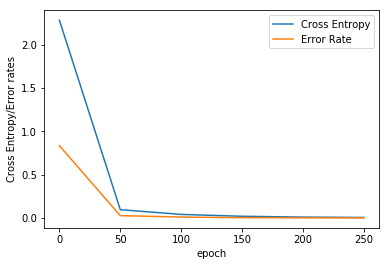

In [124]:
# 请绘制上面训练过程的损失函数曲线，以及'''错误率曲线'''！！！
plt.plot(np.arange(len(train_losses))*50, train_losses, label = 'Cross Entropy')
plt.plot(np.arange(len(train_losses))*50, np.array(train_errors) / 100.0, label = 'Error Rate')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy/Error rates')
plt.legend()

### 第四步：在测试集上测试模型

In [125]:
# 定义一个专门计算分类错误率的函数，它的基本思想是，对于预测向量predictions的每一行，
# 取最大的那个元素的下标，与标签labels中的元素做比较
#def error_rate(predictions, labels):
#    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，labels是数据之中的正确答案"""
#    predictions = np.argmax(predictions, 1)
#    return 100.0 - (
#      100.0 *
#      np.sum( predictions == labels) /
#      predictions.shape[0])

In [126]:
# 分多个batch计算测试结果
test_errors = []
test_losses = []
i = 0
test_batch_size=100

for start in range(0, len(test_X), test_batch_size):
    
    end1 = start + test_batch_size if start + test_batch_size < len(test_X) else len(test_X)
    i += 1
    if CAN_GPU:
        x = Variable(torch.FloatTensor(test_X[start:end])).cuda()
        y = Variable(torch.LongTensor(test_Y[start:end])).cuda()
    else:
        x = Variable(torch.FloatTensor(test_X[start:end]))
        y = Variable(torch.LongTensor(test_Y[start:end]))
        
    predictions = net(x)
    
    
    loss = cost(predictions, y)
    if CAN_GPU:
        test_losses.append(loss.data.cpu().numpy())
        test_errors.append(error_rate(predictions.data.cpu().numpy(), y.data.cpu().numpy()))
    else:
        test_losses.append(loss.data.numpy())
        test_errors.append(error_rate(predictions.data.numpy(), y.data.numpy()))
    
    
    print("Age:{0}\tER:{1}".format(i, test_errors[-1]))

print('平均错误率：%.4f%%'%np.mean(test_errors))

Age:1	ER:2.0900000000000034
Age:2	ER:2.1111111111111143
Age:3	ER:2.102040816326536
Age:4	ER:2.1030927835051614
Age:5	ER:2.09375
Age:6	ER:2.094736842105263
Age:7	ER:2.1063829787234027
Age:8	ER:2.0967741935483843
Age:9	ER:2.108695652173907
Age:10	ER:2.120879120879124
Age:11	ER:2.0888888888888886
Age:12	ER:2.089887640449433
Age:13	ER:2.068181818181813
Age:14	ER:2.0344827586206833
Age:15	ER:2.0116279069767415
Age:16	ER:2.023529411764713
Age:17	ER:1.9642857142857082
Age:18	ER:1.9518072289156692
Age:19	ER:1.9268292682926784
Age:20	ER:1.9506172839506206
Age:21	ER:1.9124999999999943
Age:22	ER:1.8227848101265778
Age:23	ER:1.8205128205128176
Age:24	ER:1.818181818181813
Age:25	ER:1.7894736842105203
Age:26	ER:1.7199999999999989
Age:27	ER:1.7297297297297263
Age:28	ER:1.657534246575338
Age:29	ER:1.625
Age:30	ER:1.6197183098591523
Age:31	ER:1.5714285714285694
Age:32	ER:1.5652173913043441
Age:33	ER:1.57352941176471
Age:34	ER:1.5820895522388128
Age:35	ER:1.606060606060609
Age:36	ER:1.6153846153846132
A

### 用单个图像进行测试

In [127]:
#随便从数据集中读入一张图片，并绘制出来
#idx = 100
#muteimg = test_data[idx, 0, :, :]
#plt.imshow(muteimg)

In [128]:
# 计算识别结果
#x = Variable(torch.FloatTensor(test_X[idx, :].reshape(1, -1)))
#predict = net(x)
#np.argmax(predict.data.numpy())

## 升级版

#### 如果你已经运行跑通上面的所有代码，那么请你尝试对其进行更改，让测试集上面的识别错误率进一步下降，看看能不能到1%以下

提示：可以考虑增加层的深度

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第II课的配套源代码

### 参数测试与总结

* 两层linear(150,50) -> 2.0131%
* 两层linear(80,40)  -> 2.3602%
* 两层linear(100,30)  -> 1.9346%   测试集错误率在每一个batch上表现稳定
* 两层linear(120,30)  -> 1.5356%   错误率下降明显
* 两层linear(128,32)  -> 1.6536%   错误率下降明显，不到300次迭代两次监测错误率降低小于0.0005
* 三层linear(128,32,16)  -> 2.2962%   与两层区别不明显
* 两层linear(150,30)  -> 1.4601%   训练集错误率0.02%
* 去掉最后一层的sigmoid之后训练速度明显增快，而且错误率下降明显
